In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


In [2]:
btc = pd.read_csv('/Users/nikita/Desktop/monero/BTC.csv', sep=',', encoding='utf-8')

In [3]:
btc.columns = ['date', 'close', 'high', 'low', 'open', 'volume', '%']

In [4]:
btc['close'] = btc['close'].str.replace('.', '')
btc['high'] = btc['high'].str.replace('.', '')
btc['low'] = btc['low'].str.replace('.', '')
btc['open'] = btc['open'].str.replace('.', '')
btc['volume'] = btc['volume'].str.replace('.', '')
btc['%'] = btc['%'].str.replace('.', '')
btc['%'] = btc['%'].str.replace('%', '') 

btc['close'] = btc['close'].str.replace(',', '.').astype(float)
btc['high'] = btc['high'].str.replace(',', '.').astype(float)
btc['low'] = btc['low'].str.replace(',', '.').astype(float)
btc['open'] = btc['open'].str.replace(',', '.').astype(float)
btc['volume'] = btc['volume'].str.replace(',', '.')  # Remove commas
btc['%'] = btc['%'].str.replace(',', '.').astype(float)


btc['volume'] = btc['volume'].str.replace('K', 'e3')  # Replace 'K' with 'e3'
btc['volume'] = btc['volume'].str.replace('M', 'e6')  # Replace 'M' with 'e6'
btc['volume'] = btc['volume'].str.replace('B', 'e9')  # Replace 'B' with 'e9'
btc['volume'] = btc['volume'].astype(float)  # Convert to float

In [5]:
btc = btc.iloc[::-1].reset_index(drop=True)
btc = btc.set_index('date')
btc.index = pd.to_datetime(btc.index)

/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_16557/3883492016.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  btc.index = pd.to_datetime(btc.index)


In [6]:
btc

close     high      low     open   volume     %
date                                                         
2012-09-27     12.3     12.3     12.4     12.2  19330.0  0.00
2012-09-28     12.4     12.3     12.4     12.1  26680.0  0.65
2012-09-29     12.4     12.4     12.5     12.2  17060.0  0.00
2012-09-30     12.4     12.4     12.4     12.3   7790.0  0.00
2012-10-01     12.4     12.4     12.5     12.3  24830.0  0.00
...             ...      ...      ...      ...      ...   ...
2025-04-23  93697.7  93442.2  94462.6  91963.4  90350.0  0.27
2025-04-24  93980.3  93696.3  94001.0  91673.0  66680.0  0.30
2025-04-25  94676.9  93979.4  95718.6  92867.2  92040.0  0.74
2025-04-26  94631.4  94669.3  95207.0  93891.8  33770.0 -0.05
2025-04-27  93873.1  94631.4  95324.4  93640.7  35890.0 -0.80

[4596 rows x 6 columns]

## EDA

In [7]:
eda_btc = btc.copy()

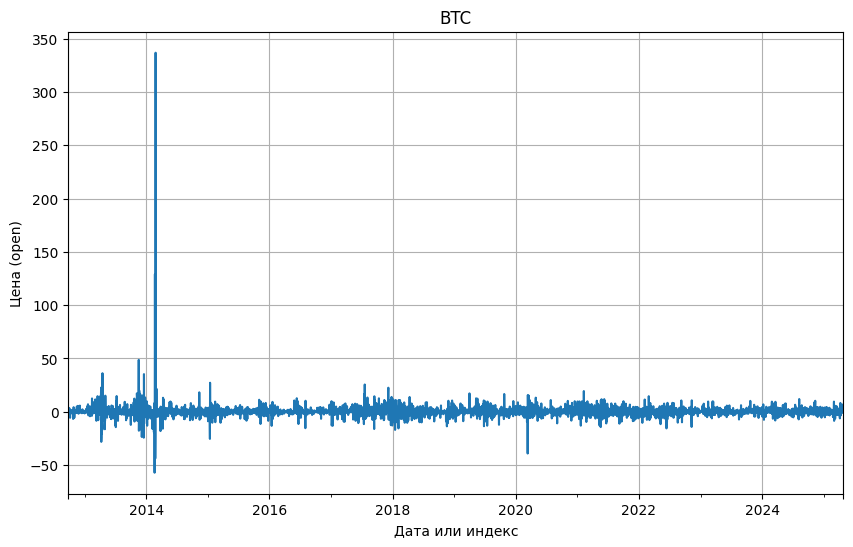

In [8]:
eda_btc['%'].plot(figsize=(10, 6), title='BTC', grid=True)
plt.xlabel('Дата или индекс')
plt.ylabel('Цена (open)')
plt.show()

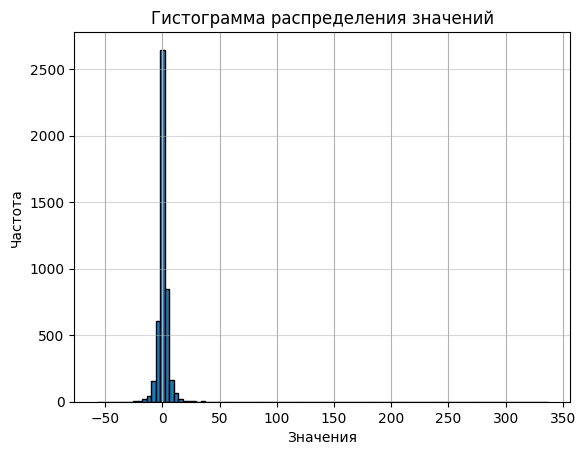

In [9]:
eda_btc['%'].hist(bins=100, edgecolor='black')  # bins - количество интервалов
plt.title('Гистограмма распределения значений')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [10]:
def find_outliers_zscore(data, column, threshold=3):
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    outliers = data[abs(z_scores) > threshold]
    return outliers

In [11]:
outliers = find_outliers_zscore(eda_btc, '%')
print(outliers)

              close     high      low     open     volume       %
date                                                             
2013-04-09    230.0    187.5    240.1    186.5   105840.0   22.67
2013-04-10    165.0    230.0    266.0    105.0   190180.0  -28.26
2013-04-11    124.9    165.0    188.7    110.2   118750.0  -24.30
2013-04-13     93.0    117.0    130.0     85.5   238350.0  -20.51
2013-04-17     93.1     68.4     98.8     63.3   327630.0   36.15
2013-11-18    785.4    528.3    787.9    522.0    72070.0   48.67
2013-12-06    845.0   1106.3   1118.9    800.1    53520.0  -23.62
2013-12-18    541.0    715.0    717.0    454.9   110500.0  -24.34
2013-12-19    732.0    541.0    746.0    522.4    45760.0   35.30
2014-02-20    111.9    261.5    271.6    109.2   102180.0  -57.21
2014-02-22    255.6    111.6    290.6     96.7    72170.0  129.11
2014-02-23    310.2    255.6    349.1    220.3    38550.0   21.35
2014-02-24    174.0    310.2    316.9    131.9    95120.0  -43.90
2014-02-25

In [12]:
filter_eda_btc = eda_btc[eda_btc.index > '2014-02-27']

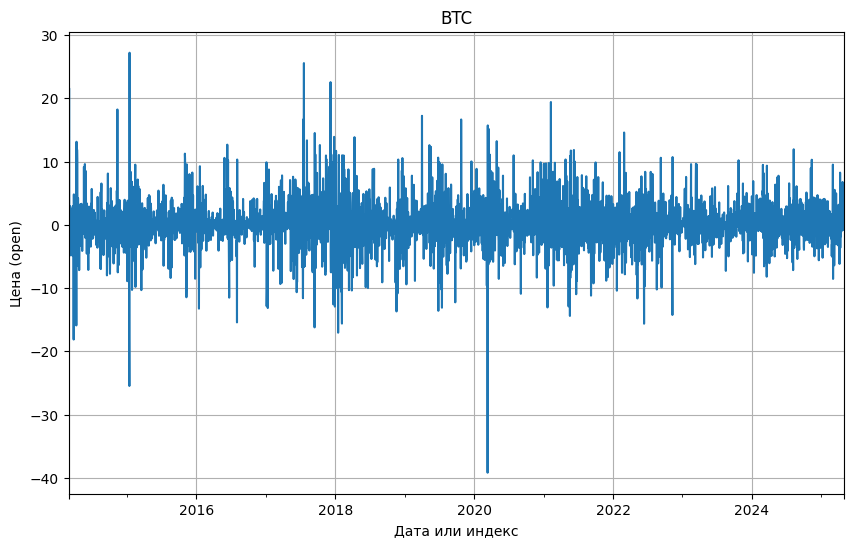

In [13]:
filter_eda_btc['%'].plot(figsize=(10, 6), title='BTC', grid=True)
plt.xlabel('Дата или индекс')
plt.ylabel('Цена (open)')
plt.show()

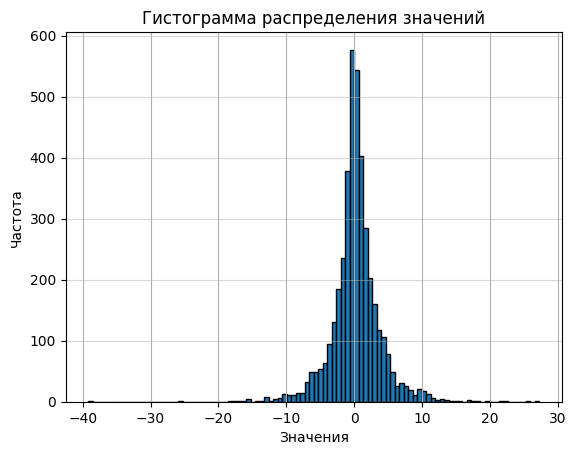

In [14]:
filter_eda_btc['%'].hist(bins=100, edgecolor='black')  # bins - количество интервалов
plt.title('Гистограмма распределения значений')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()

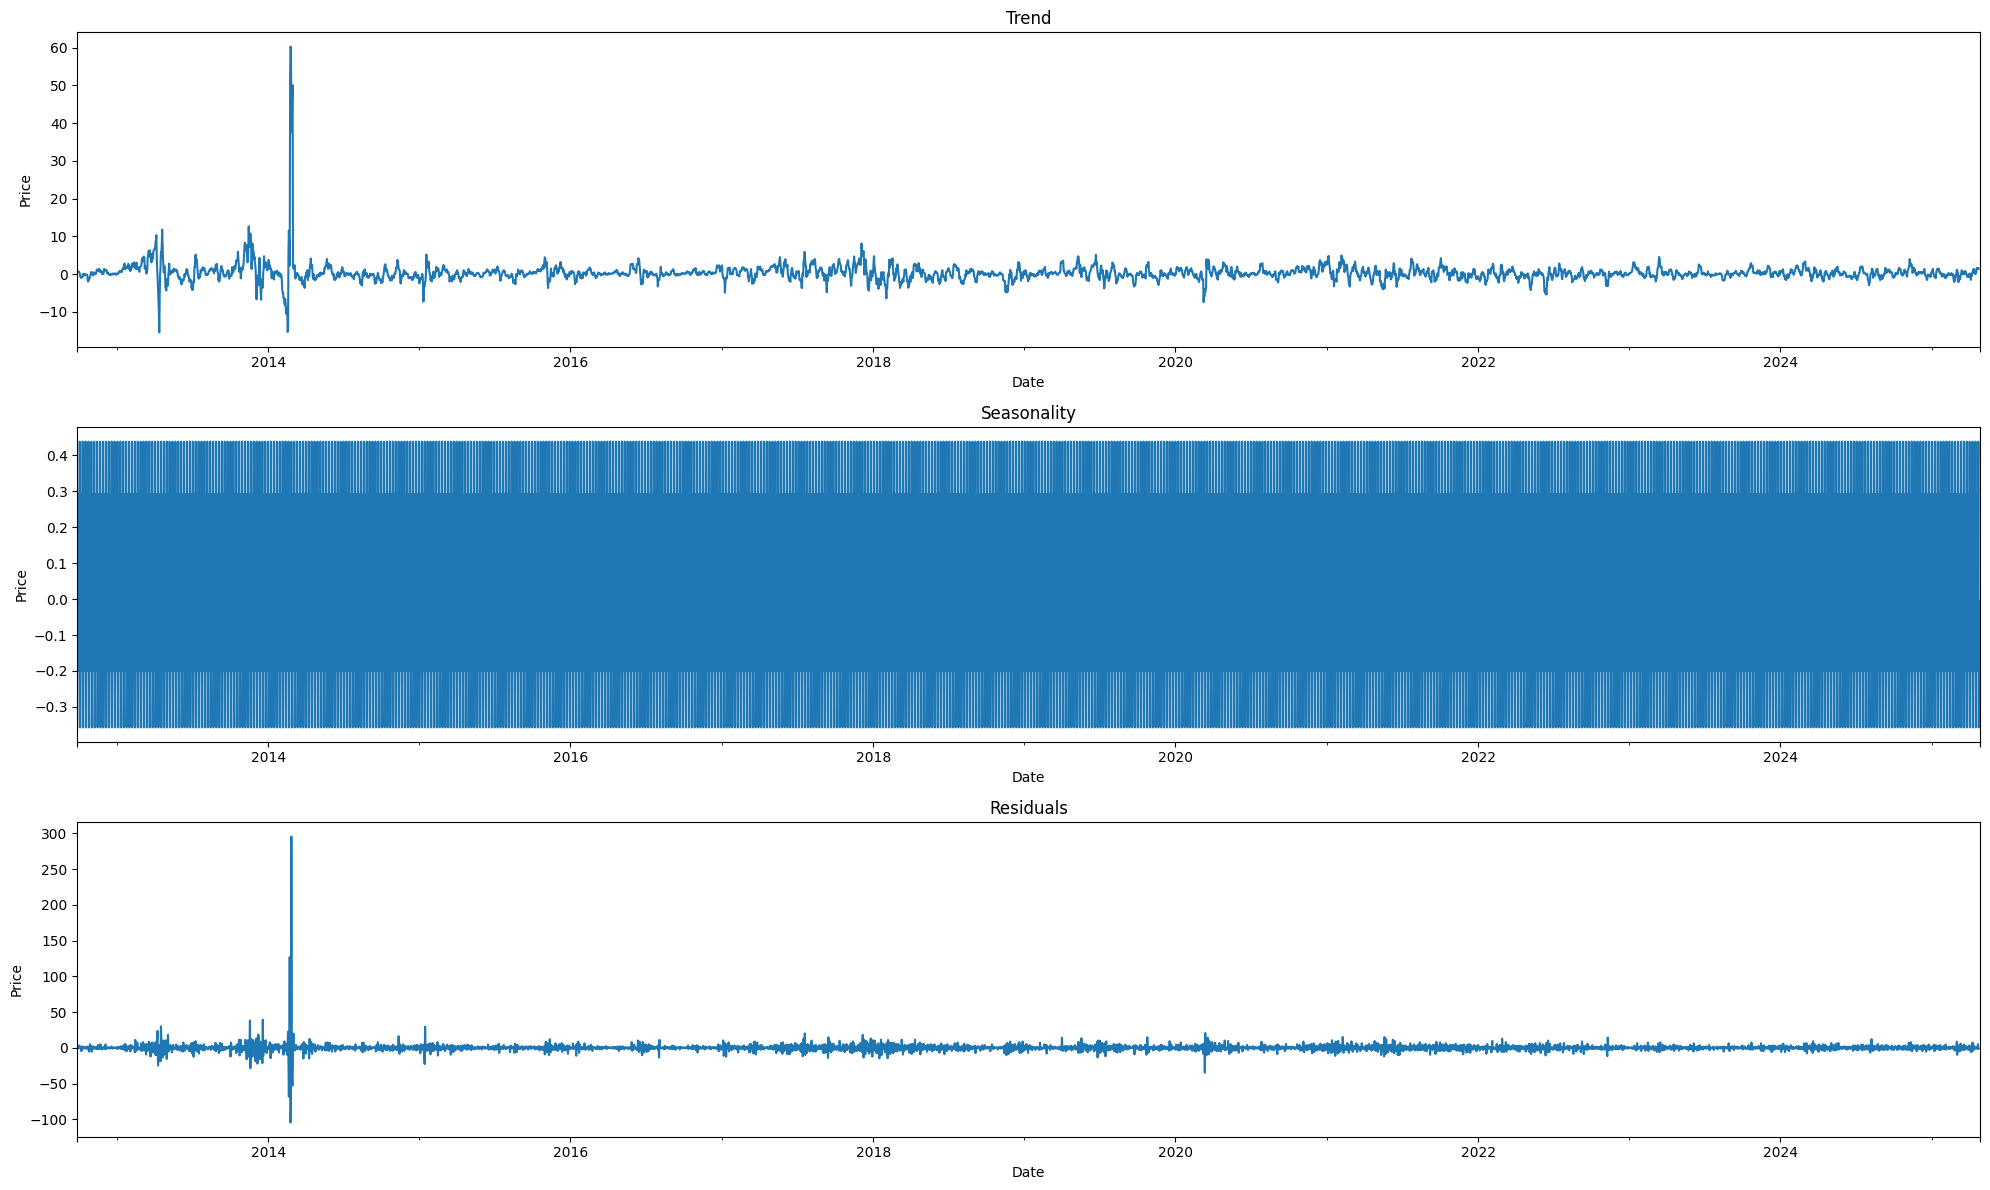

In [15]:
#Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(btc['%'])


# Построим графики этих составляющих ряда
plt.figure(figsize=(20, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()

In [16]:
# ряд первых разностей временного ряда
btc_shift =btc - btc.shift(fill_value=0)

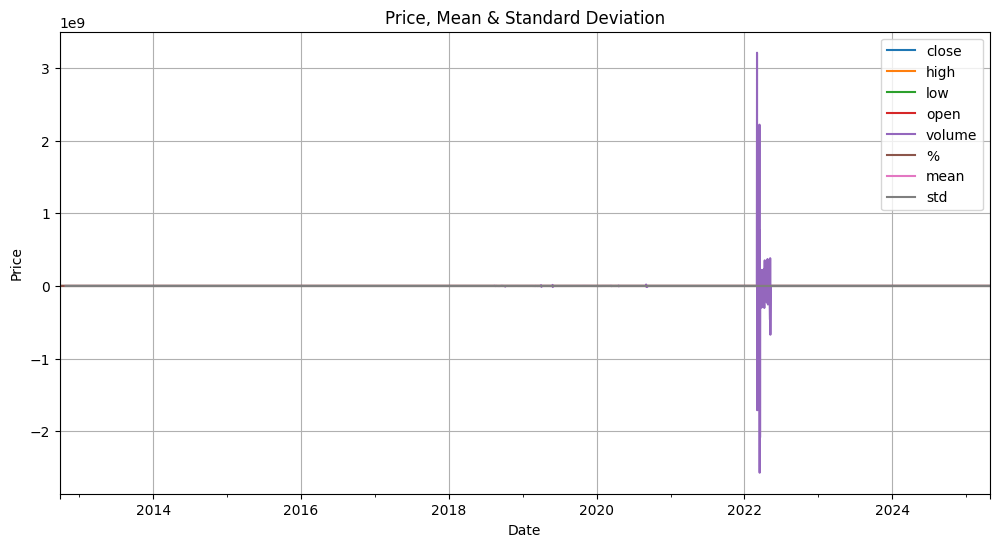

In [17]:
#скользящее среднее и скользящее стандартное отклонение ряда первых разностей

btc_shift['mean'] = btc_shift['%'].shift().rolling(30).mean()
btc_shift['std'] = btc_shift['%'].shift().rolling(30).std()

# график первых разностей временного ряда, его скользящего среднего
# и скользящего стандартного отклонения
btc_shift.plot(figsize=(12, 6))
plt.title('Price, Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

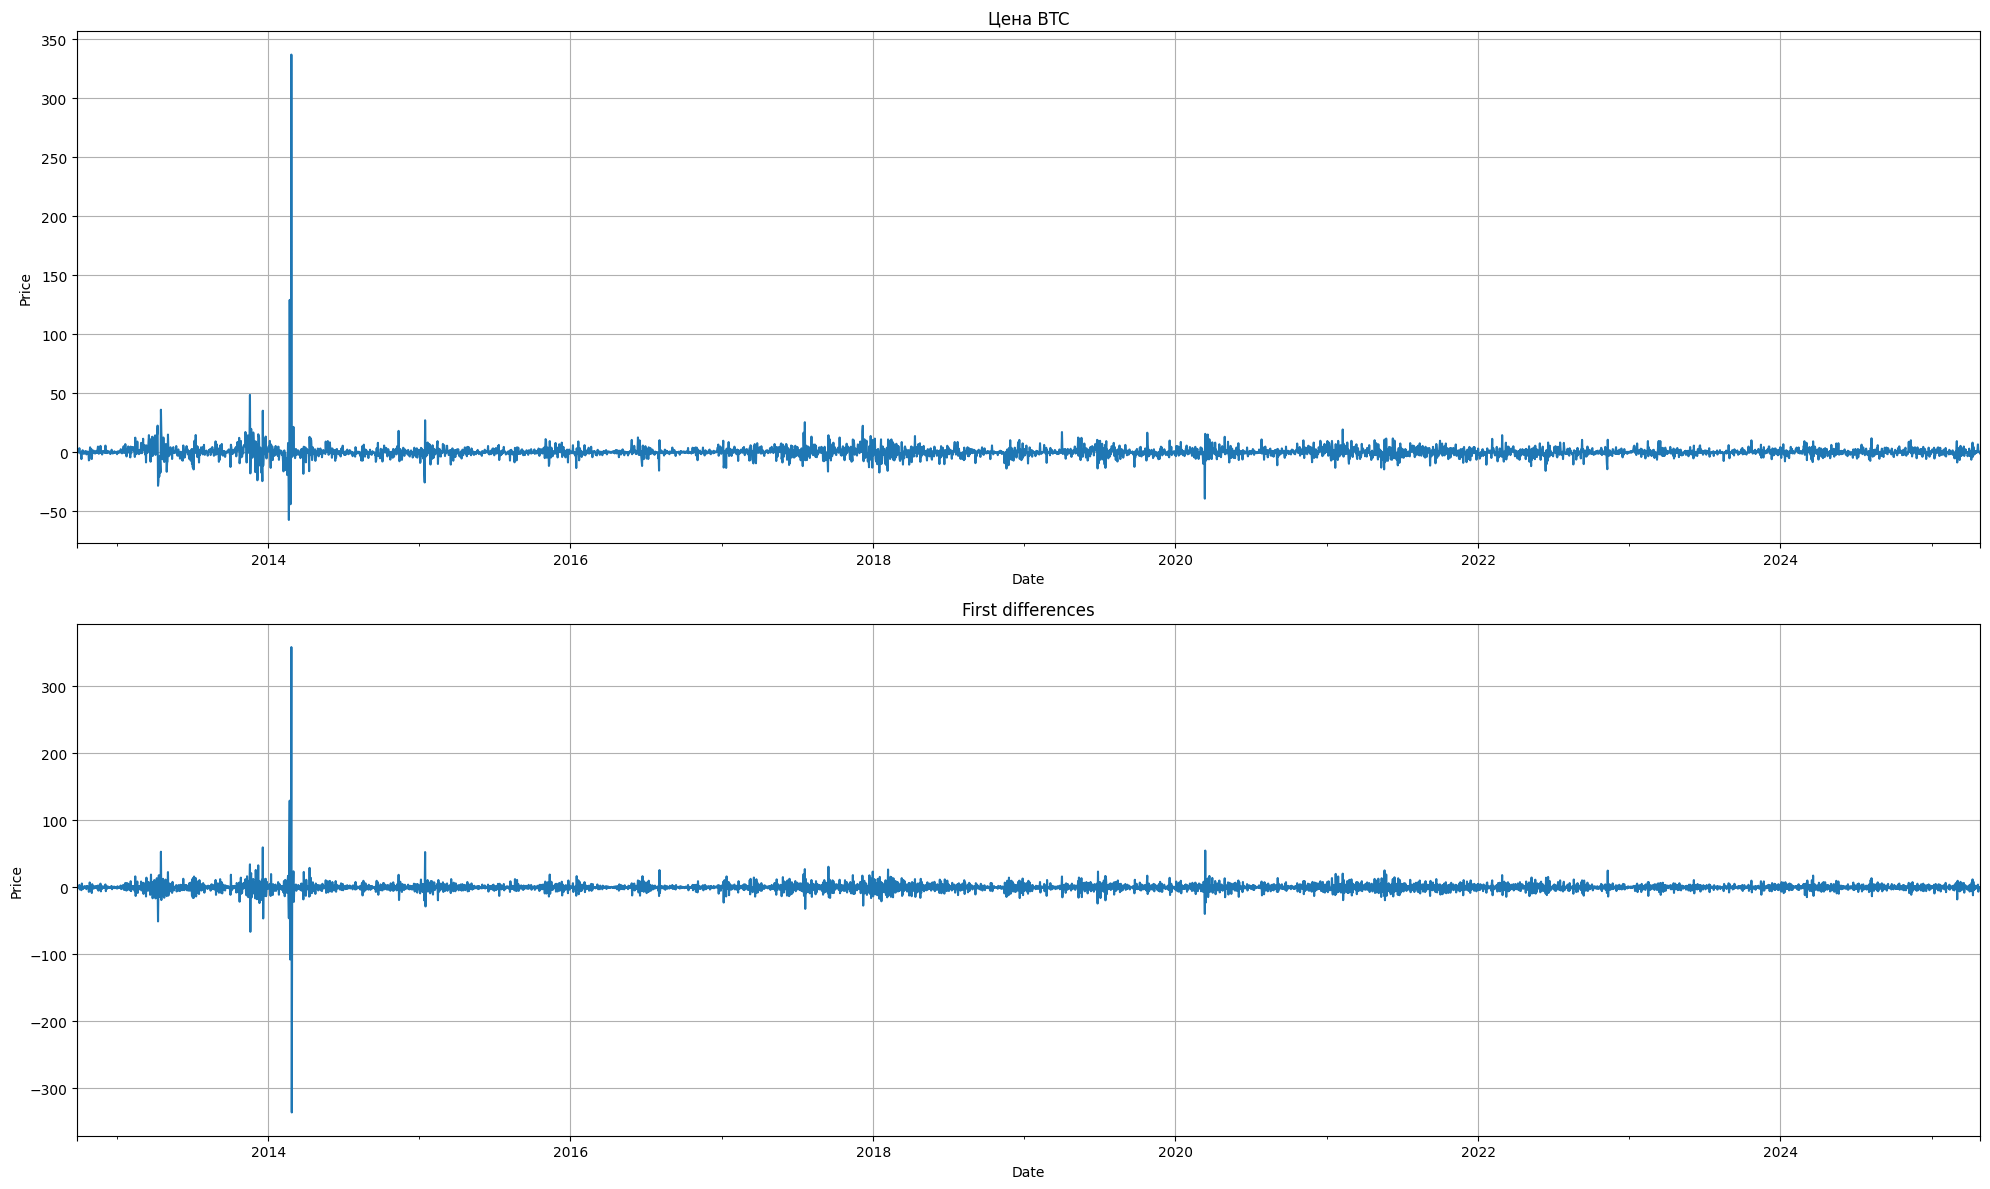

In [18]:
# Построим графики исходного временного ряда и его первых разностей
plt.figure(figsize=(20, 12))
plt.subplot(211)
btc['%'].plot(ax=plt.gca())
plt.title('Цена BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

plt.subplot(212)
btc_shift['%'].plot(ax=plt.gca())
plt.title('First differences')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

plt.tight_layout()

<Figure size 2400x1200 with 0 Axes>

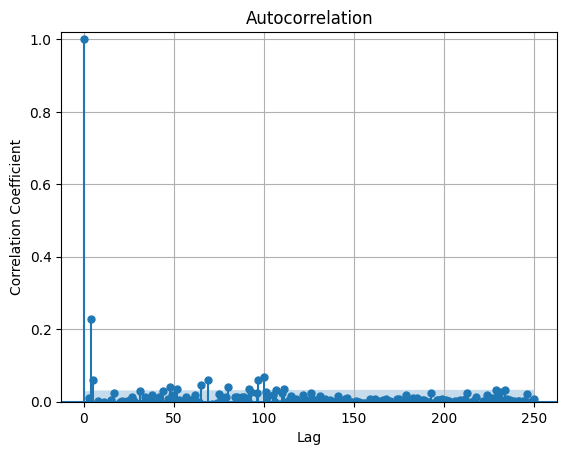

In [19]:
#График автокорреляционной функции при лаге 250
plt.figure(figsize=(24, 12))
plot_acf(btc["%"], lags = 250)
plt.xlabel('Lag')
plt.ylabel('Сorrelation Сoefficient')
#plt.xlim([0, 100.02])
plt.ylim([0, 1.02])
plt.grid()
plt.show()

In [20]:
# Проведем тест Дики-Фуллера
test = adfuller(btc["%"])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен при 5% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 5% уровне значимости')

if test[0]> test[4]['1%']:
    print('есть единичные корни, ряд не стационарен при 1% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 1% уровне значимости')

adf:  -23.43708285313024
p-value:  0.0
Critical values:  {'1%': -3.4317764144860807, '5%': -2.8621703084687975, '10%': -2.5671055161070027}
единичных корней нет, ряд стационарен при 5% уровне значимости
единичных корней нет, ряд стационарен при 1% уровне значимости


### Создание новых признаков

In [21]:
btc

close     high      low     open   volume     %
date                                                         
2012-09-27     12.3     12.3     12.4     12.2  19330.0  0.00
2012-09-28     12.4     12.3     12.4     12.1  26680.0  0.65
2012-09-29     12.4     12.4     12.5     12.2  17060.0  0.00
2012-09-30     12.4     12.4     12.4     12.3   7790.0  0.00
2012-10-01     12.4     12.4     12.5     12.3  24830.0  0.00
...             ...      ...      ...      ...      ...   ...
2025-04-23  93697.7  93442.2  94462.6  91963.4  90350.0  0.27
2025-04-24  93980.3  93696.3  94001.0  91673.0  66680.0  0.30
2025-04-25  94676.9  93979.4  95718.6  92867.2  92040.0  0.74
2025-04-26  94631.4  94669.3  95207.0  93891.8  33770.0 -0.05
2025-04-27  93873.1  94631.4  95324.4  93640.7  35890.0 -0.80

[4596 rows x 6 columns]

In [22]:
df_new = btc.copy()

In [23]:
# Сдвигаем только столбец '%' на 1 вниз (значения уходят вниз, первая строка станет NaN)
df_new['%'] = df_new['%'].shift(1)

# Заполняем NaN (например, 0 или оставляем как есть)
btc = btc.dropna()

df_new

close     high      low     open   volume     %
date                                                         
2012-09-27     12.3     12.3     12.4     12.2  19330.0   NaN
2012-09-28     12.4     12.3     12.4     12.1  26680.0  0.00
2012-09-29     12.4     12.4     12.5     12.2  17060.0  0.65
2012-09-30     12.4     12.4     12.4     12.3   7790.0  0.00
2012-10-01     12.4     12.4     12.5     12.3  24830.0  0.00
...             ...      ...      ...      ...      ...   ...
2025-04-23  93697.7  93442.2  94462.6  91963.4  90350.0  6.77
2025-04-24  93980.3  93696.3  94001.0  91673.0  66680.0  0.27
2025-04-25  94676.9  93979.4  95718.6  92867.2  92040.0  0.30
2025-04-26  94631.4  94669.3  95207.0  93891.8  33770.0  0.74
2025-04-27  93873.1  94631.4  95324.4  93640.7  35890.0 -0.05

[4596 rows x 6 columns]

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    data_new['month'] = data.index.month

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['%'].shift(lag)

    data_new['rolling_mean'] = data_new['%'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [25]:
df_new = make_features(df_new, max_lag = 28, rolling_mean_size = 50)
df_new.head()

close  high   low  open   volume     %  day  dayofweek  month  \
date                                                                        
2012-09-27   12.3  12.3  12.4  12.2  19330.0   NaN   27          3      9   
2012-09-28   12.4  12.3  12.4  12.1  26680.0  0.00   28          4      9   
2012-09-29   12.4  12.4  12.5  12.2  17060.0  0.65   29          5      9   
2012-09-30   12.4  12.4  12.4  12.3   7790.0  0.00   30          6      9   
2012-10-01   12.4  12.4  12.5  12.3  24830.0  0.00    1          0     10   

            lag_1  ...  lag_20  lag_21  lag_22  lag_23  lag_24  lag_25  \
date               ...                                                   
2012-09-27    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-09-28    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-09-29   0.00  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-09-30   0.65  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-10-01   0.00  ...     NaN     NaN     NaN     NaN     NaN     NaN   

            lag_26  lag_27  lag_28  rolling_mean  
date                                              
2012-09-27     NaN     NaN     NaN           NaN  
2012-09-28     NaN     NaN     NaN           NaN  
2012-09-29     NaN     NaN     NaN           NaN  
2012-09-30     NaN     NaN     NaN           NaN  
2012-10-01     NaN     NaN     NaN           NaN  

[5 rows x 38 columns]

In [26]:
df_new = df_new.dropna()

In [27]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.01)
train = train.dropna()

print(train.shape)

print(test.shape)
print(train.index.min(), train.index.max())

print(test.index.min(), test.index.max())

(4499, 38)
(46, 38)
2012-11-17 00:00:00 2025-03-12 00:00:00
2025-03-13 00:00:00 2025-04-27 00:00:00


In [28]:
X_train = train.drop(['%'], axis=1)
y_train = train['%']

X_test = test.drop(['%'], axis=1)
y_test = test['%']

## Обучение моделей

In [29]:
def calculate_metrics(y_true, y_pred):
    """Calculates MSE, RMSE, MAE, and MAPE."""

    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    # Handle potential division by zero in MAPE calculation
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    mape = np.nan_to_num(mape) #Replaces nan with 0

    return mse, rmse, mae, mape


In [30]:
# Словать с метриками для обучения моделей
scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

In [31]:
# Определяем тип кросс-валидаци на временных рядах
tscv = TimeSeriesSplit(n_splits=10)

In [32]:
model = LinearRegression()

In [33]:
start_time = time.time()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

lr_time = time.time() - start_time

In [34]:
y_predict = pd.Series(y_predict, index=X_test.index)

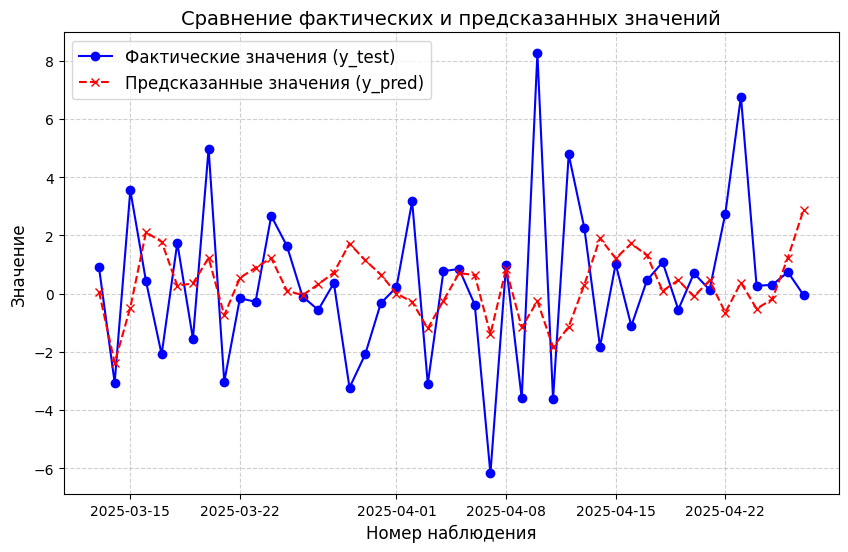

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_predict, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [36]:
y_true = (y_test > 0).astype(int)
y_pred = (y_predict > 0).astype(int)


In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [38]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

TN: 7, FP: 13, FN: 9, TP: 17


In [39]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

Accuracy: 0.52


Elastic

In [40]:
# Используем GridSearch для подбора гиперпараметров модели
param_grid = {
    'alpha': [1 for i in range(0, 10, 1)],
    'l1_ratio': [1 for i in range(0, 10, 1)]
}


In [41]:
Elastic = GridSearchCV(ElasticNet(random_state=12345), param_grid, cv=tscv, scoring='neg_root_mean_squared_error').fit(X_train, y_train)

/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e+03, tolerance: 2.078e+00
  model = cd_fast.enet_coordinate_descent(
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e+04, tolerance: 1.659e+01
  model = cd_fast.enet_coordinate_descent(
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

KeyboardInterrupt: 

In [ ]:
y_pred = Elastic.best_estimator_.predict(X_test)

In [ ]:
y_true = (y_test > 0).astype(int)
y_pred = (y_pred > 0).astype(int)


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

Accuracy: 0.48


### Random Forest

In [ ]:
model = RandomForestRegressor()

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}



In [ ]:
RandomForest = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
# выведите лучшие гиперпараметры
print('Гиперпараметры', RandomForest.best_params_)

start_time = time.time()
# выведите лучшую метрику качества
y_pred = RandomForest.best_estimator_.predict(X_test)
rf_mse, rf_rmse, rf_mae, rf_mape = calculate_metrics(y_test, y_pred)
rf_time = time.time() - start_time

Гиперпараметры {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
y_true = (y_test > 0).astype(int)
y_pred = (y_pred > 0).astype(int)

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

Accuracy: 0.57


### LGBM_Regressor

In [ ]:
model = LGBMRegressor()

In [ ]:
# Определим набор гиперпараметров для кросс-валидации и используем GridSearch для их подбора
param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],  # Boosting types to try
    'num_leaves': [31, 63, 127],  # Number of leaves in each tree
    'learning_rate': [0.01, 0.1, 0.05],  # Learning rate
    'n_estimators': [100, 500, 1000],  # Number of boosting rounds
    'max_depth': [-1, 5, 10],  # Maximum tree depth (-1 means no limit)
    'min_child_samples': [20, 50, 100],  # Minimum samples required in a leaf node
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'subsample_freq': [0, 1],  # Frequence of subsample
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}


In [ ]:
start_time = time.time()

LGBMR = RandomizedSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)

lgbmr_time = time.time() - start_time

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 1189, in fit
    super().fit(
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
  File "/Users/nikita/Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
y_pred = LGBMR.best_estimator_.predict(X_test)
lgbmr_mse, lgbmr_rmse, lgbmr_mae, lgbmr_mape = calculate_metrics(y_test, y_pred)

In [ ]:
y_true = (y_test > 0).astype(int)
y_pred = (y_pred > 0).astype(int)

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

Accuracy: 0.54
